# Physics-informed neural network (PINN) demo

In this demo we will code a PINN from scratch in `PyTorch` and use it to solve simulation and inversion problems related to the damped harmonic oscillator.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Insipration & Acknoledgments

This notebook follows lab exercise from [ETH Zürich Deep Learning in Scientific Computing Master's course 2023](https://github.com/benmoseley/DLSC-2023/tree/main).

## Problem overview

We are going to use a PINN to solve problems related to the **damped harmonic oscillator**:

<img src="oscillator.gif" width="500">

We are interested in modelling the displacement of the mass on a spring (green box) over time.

This is a canonical physics problem, where the displacement, $u(t)$, of the oscillator as a function of time can be described by the following differential equation:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

where $m$ is the mass of the oscillator, $\mu$ is the coefficient of friction and $k$ is the spring constant.

We will focus on solving the problem in the **under-damped state**, i.e. where the oscillation is slowly damped by friction (as displayed in the animation above). 

Mathematically, this occurs when:

$$
\delta < \omega_0~,~~~~~\mathrm{where}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Furthermore, we consider the following initial conditions of the system:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

For this particular case, the exact solution is known and given by:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$



For a more detailed mathematical description of the harmonic oscillator, check out this blog post: https://beltoforion.de/en/harmonic_oscillator/.

## Workflow overview

We will use a PINN to **find the parameters** of the system, **knownig ODE and some noisy observations** of the oscillator's displacement.

## Initial setup

First, we define a few helper functions.

In [2]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Task 3: train a PINN to invert for underlying parameters

#### Task

The third task is to use a PINN to **invert** for underlying parameters.

Specifically, our inputs and outputs are:

- Inputs: noisy observations of the oscillator's displacement, $u_{\mathrm{obs}}$
- Outputs: estimate $\mu$, the coefficient of friction

#### Approach

Similar to above, the PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
N\!N(t;\theta) \approx u(t)~,
$$

However here we assume $\mu$ is **not known** and we treat it as an additional **learnable parameter** when training the PINN.

#### Loss function

The PINN is trained with the loss function:

$$
\mathcal{L}(\theta, \mu)= \frac{1}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] N\!N(t_{i};\theta)  \right)^2 + \frac{\lambda}{M} \sum^{M}_{j} \left( N\!N(t_{j};\theta) - u_{\mathrm{obs}}(t_{j}) \right)^2
$$

True value of mu: 4


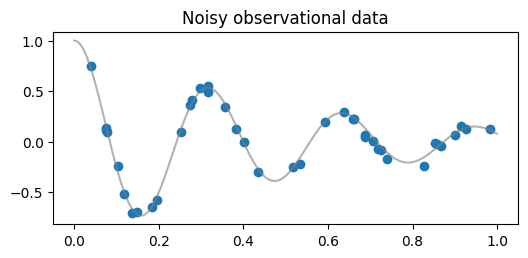

In [3]:
# first, create some noisy observational data
torch.manual_seed(123)
d, w0 = 2, 20
print(f"True value of mu: {2*d}")
t_obs = torch.rand(40).view(-1,1)
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

plt.figure(figsize=(6,2.5))
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()

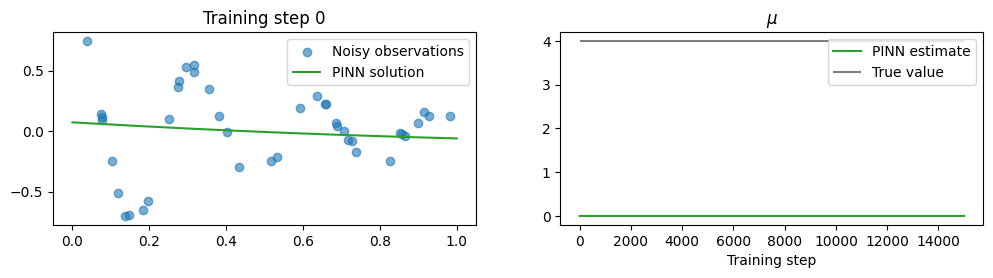

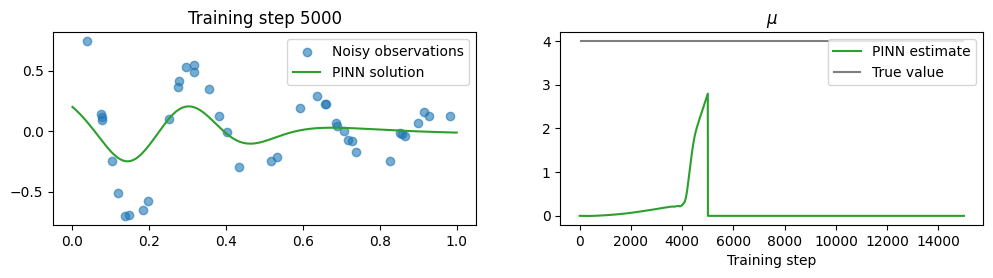

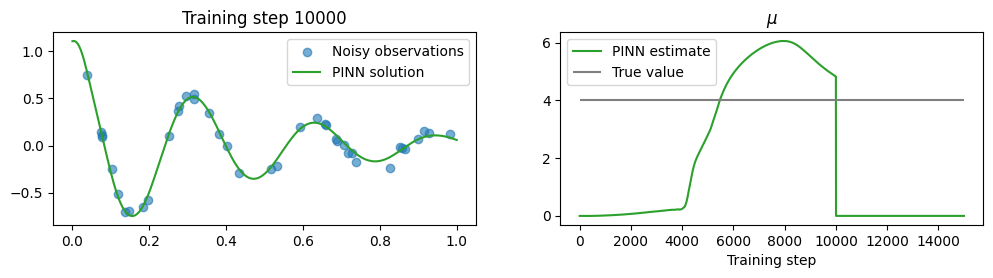

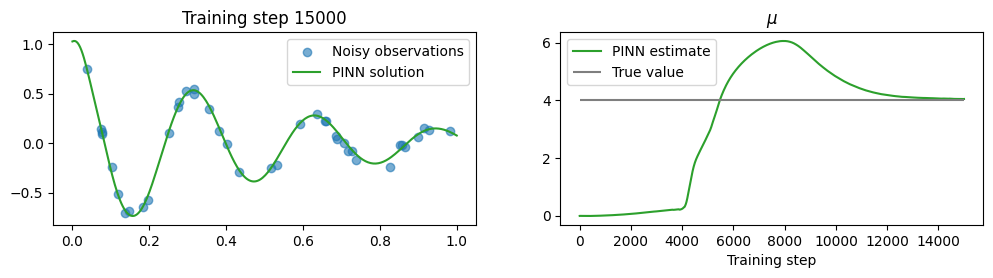

In [4]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(1,1,32,3)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# (30, 1)

# train the PINN
d, w0 = 2, 20
_, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

# treat mu as a learnable parameter, add it to optimiser
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
optimiser = torch.optim.Adam(list(pinn.parameters())+[mu],lr=1e-3)

mu_history = np.zeros(15001)
for i in range(15001):
    optimiser.zero_grad()
    
    # compute each term of the PINN loss function above
    # using the following hyperparameters
    lambda1 = 1e4
    
    # compute physics loss
    u = pinn(t_physics)# (30, 1)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]# (30, 1)
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]# (30, 1)
    loss1 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    # compute data loss
    u = pinn(t_obs)
    loss2 = torch.mean((u - u_obs)**2)
    
    # backpropagate joint loss, take optimiser step
    loss = loss1 + lambda1*loss2
    loss.backward()
    optimiser.step()
    
    # record mu value
    mu_history[i] = mu.item()
    
    # plot the result as training progresses
    if i % 5000 == 0: 
        u = pinn(t_test).detach()
        plt.figure(figsize=(12,2.5))
        
        plt.subplot(1,2,1)
        plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy observations", alpha=0.6, color="tab:blue")
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.title("$\mu$")
        plt.plot(mu_history, label="PINN estimate", color="tab:green")
        plt.hlines(2*d, 0, len(mu_history), label="True value", color="tab:grey")
        plt.xlabel("Training step")
        plt.legend()
        
        plt.show()